In [12]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

In [14]:
base_dir = r"C:\Users\DELL\Documents\Python\Data"

In [15]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [16]:
train_plain_dir = os.path.join(train_dir,'plain')
train_pothole_dir = os.path.join(train_dir,'pothole')

In [17]:
test_plain_dir = os.path.join(test_dir,'plain')
test_pothole_dir = os.path.join(test_dir,'pothole')

In [18]:
validation_plain_dir = os.path.join(validation_dir,'plain')
validation_pothole_dir = os.path.join(validation_dir,'pothole')

In [19]:
# Sanity checks
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))

total training plain images : 210
total training pothole images :  211
total validation plain images : 70
total validation pothole images : 70
total test plain images : 70
total test pothole images : 70


In [20]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

8.15004725667_6fbc5f2581_b.jpg


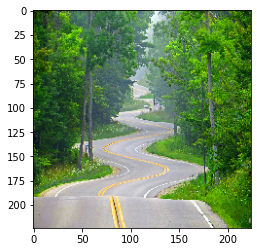

3 (2).jpg


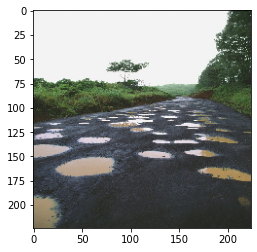

62.roads-of-the-future.jpeg


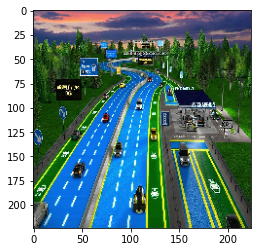

17.jpg


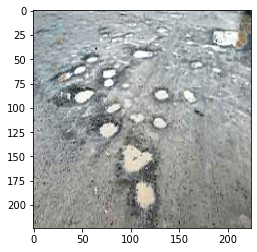

In [21]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

In [22]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [23]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.


C:\Users\DELL\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [25]:
# Debug
print(train_features)
print(train_labels)

[[[[0.16513517 0.         0.         ... 0.         1.20048833
    0.        ]
   [0.11629983 0.         0.         ... 0.         0.35450524
    0.        ]
   [0.18263209 0.         0.         ... 0.         0.23125833
    0.        ]
   ...
   [0.60271513 0.         0.         ... 0.         0.67434919
    0.        ]
   [0.08072942 0.         0.         ... 0.         1.04621971
    0.        ]
   [0.         0.         0.         ... 0.         1.03363383
    0.        ]]

  [[0.03477107 0.         0.         ... 0.         1.32980132
    0.        ]
   [0.2859897  0.         0.06276211 ... 0.         0.58705789
    0.        ]
   [0.         0.         0.26706821 ... 0.         0.41036743
    0.        ]
   ...
   [0.5575313  0.         1.11178446 ... 0.         0.42073116
    0.        ]
   [0.46018204 0.         0.93383598 ... 0.         0.83609748
    0.        ]
   [0.22608745 0.         0.         ... 0.         0.84581625
    0.        ]]

  [[1.20622575 0.         0.      

In [26]:
train_features.shape

(420, 7, 7, 512)

# Modeling

In [30]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [34]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 43ms/step - loss: 0.6104 - acc: 0.8024 - val_loss: 0.3622 - val_acc: 0.9286
Epoch 2/100
14/14 [==============================] - 0s 34ms/step - loss: 0.2576 - acc: 0.9214 - val_loss: 0.1674 - val_acc: 0.9429
Epoch 3/100
14/14 [==============================] - 0s 32ms/step - loss: 0.1248 - acc: 0.9667 - val_loss: 0.1801 - val_acc: 0.9500
Epoch 4/100
14/14 [==============================] - 0s 33ms/step - loss: 0.0569 - acc: 0.9762 - val_loss: 0.1654 - val_acc: 0.9500
Epoch 5/100
14/14 [==============================] - 0s 33ms/step - loss: 0.0144 - acc: 0.9952 - val_loss: 0.1446 - val_acc: 0.9500
Epoch 6/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.1479 - val_acc: 0.9571
Epoch 7/100
14/14 [==============================] - 0s 34ms/step - loss: 0.0103 - acc: 0.9976 - val_loss: 0.1480 - val_acc: 0.9571
Epoch 8/100
14/14 [==============================] - 0s 34ms/step - loss: 0.

In [35]:
# Save model
model.save('pothole_fcl.h5')

# Model evaluation

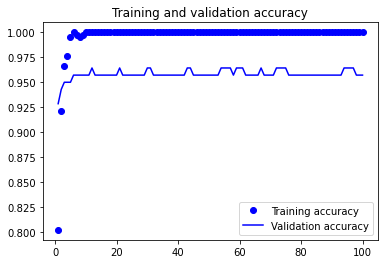

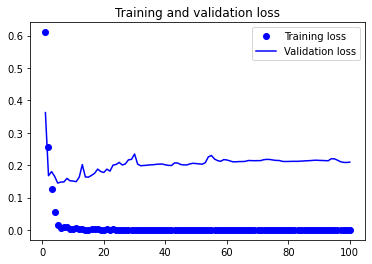

In [36]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model in action

In [37]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

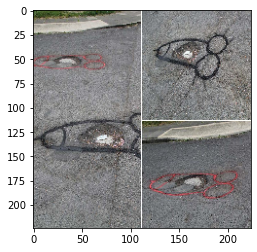

Pothole


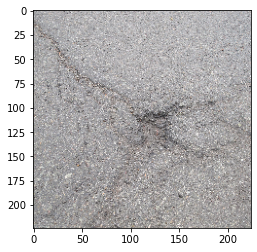

Pothole


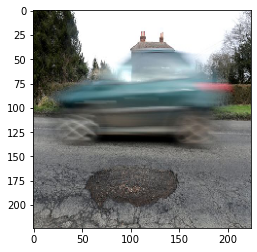

Pothole


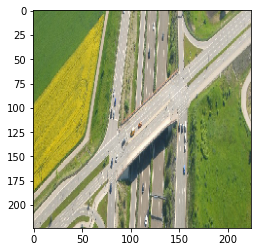

Plain


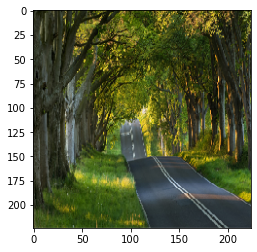

Plain


In [38]:
# Visualize predictions
visualize_predictions(model, 5)

# GLOBAL AVG POOLING

In [39]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [41]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 0s 12ms/step - loss: 0.6988 - acc: 0.5095 - val_loss: 0.6777 - val_acc: 0.5714
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6439 - acc: 0.7429 - val_loss: 0.6474 - val_acc: 0.6857
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6124 - acc: 0.8214 - val_loss: 0.6164 - val_acc: 0.8143
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5811 - acc: 0.8405 - val_loss: 0.5901 - val_acc: 0.8357
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5526 - acc: 0.8952 - val_loss: 0.5661 - val_acc: 0.8357
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5263 - acc: 0.9095 - val_loss: 0.5425 - val_acc: 0.8429
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5018 - acc: 0.9119 - val_loss: 0.5216 - val_acc: 0.8571
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.4792 - 

Epoch 63/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1576 - acc: 0.9571 - val_loss: 0.2232 - val_acc: 0.9357
Epoch 64/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1559 - acc: 0.9571 - val_loss: 0.2241 - val_acc: 0.9286
Epoch 65/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1544 - acc: 0.9571 - val_loss: 0.2205 - val_acc: 0.9357
Epoch 66/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1528 - acc: 0.9571 - val_loss: 0.2199 - val_acc: 0.9286
Epoch 67/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1512 - acc: 0.9595 - val_loss: 0.2178 - val_acc: 0.9357
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1495 - acc: 0.9595 - val_loss: 0.2158 - val_acc: 0.9357
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1482 - acc: 0.9595 - val_loss: 0.2162 - val_acc: 0.9357
Epoch 70/100
14/14 [==============================] - 0s 4ms/step - loss: 0.

In [42]:
# Save model
model.save('pothole_gap.h5')

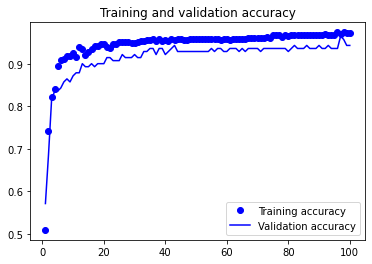

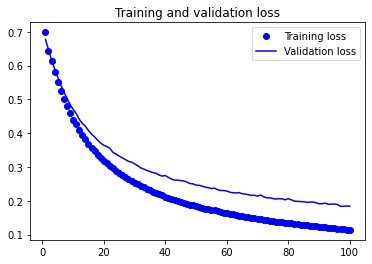

In [43]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

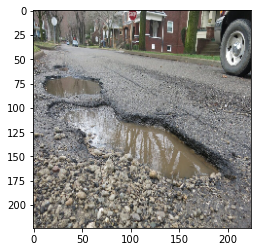

Pothole


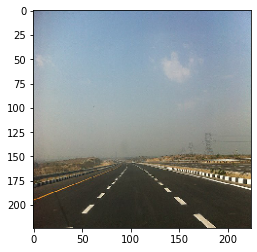

Plain


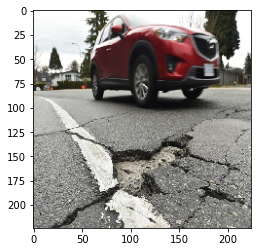

Pothole


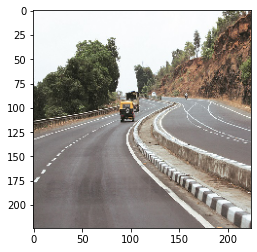

Plain


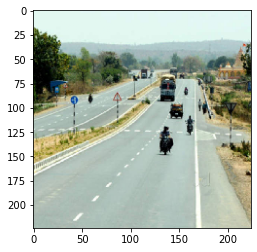

Plain


In [44]:
# Visualize predictions
visualize_predictions(model, 5)

# Linear support vector machine

In [27]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [30]:
svm_labels

array([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 1., 0.

In [28]:
svm_features.shape

(560, 7, 7, 512)

In [49]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(560,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge',max_iter=10000)  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10,verbose=10)
clf.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.982, total=   5.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.929, total=   3.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.964, total=   4.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.982, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.964, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.982, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.964, total=   4.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.982, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.964, total=   4.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.982, total=   4.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.982, total=  18.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.929, total=  17.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.964, total=  23.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.982, total=  24.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.964, total=  19.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.982, total=  26.7s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.982, total= 1.0min
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.964, total=   3.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.982, total=   2.8s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.964, total=   3.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.982, total=   2.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.982, total=   2.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.929, total=   2.6s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.6min finished


GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

In [ ]:
print("OVER!!!")

In [47]:
# Save model
model.save('pothole_svm.h5')

In [51]:
clf

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

In [52]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
cvss = np.mean(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
print(cvss)

print("\nAccuracy score (standard deviation):")
asss = np.std(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
print(asss)


Accuracy score (mean):
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.922, total=   2.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   5.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   5.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   39.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   5.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  21.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  24.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   4.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  19.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   7.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   9.0s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.2min finished


[CV] .................................... , score=0.982, total= 5.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   4.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   3.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   3.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  20.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=  20.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  15.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  17.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  16.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  13.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.5min finished


[CV] .................................... , score=0.929, total= 6.6min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.9min remaining:    0.0s



[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   3.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   3.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   4.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   5.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   5.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  16.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  15.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  23.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=  11.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  21.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  26.5s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  51.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.941, total=   5.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   3.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   2.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.940, total=   2.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   2.1s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.2min finished


[CV] .................................... , score=0.964, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.961, total=   4.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   3.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   5.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  16.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  20.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  18.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  19.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  14.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  23.5s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  45.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.961, total=   2.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   2.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.940, total=   2.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   2.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.6min finished


[CV] .................................... , score=0.982, total= 5.7min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 23.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.980, total=   2.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   3.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   5.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   28.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   30.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   35.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  15.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  12.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  21.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  21.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  21.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  26.2s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  52.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   1.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=  23.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=  15.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   2.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=  35.2s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.4min finished


[CV] .................................... , score=0.964, total= 7.5min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.961, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   3.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   4.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   5.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   3.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   36.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   5.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   2.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  20.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  22.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  15.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  23.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  19.2s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  54.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.922, total=   3.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.961, total=  53.9s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  43.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   3.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   2.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   4.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   2.3s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.8min finished


[CV] .................................... , score=0.982, total= 6.9min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 38.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.980, total=   3.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   3.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   5.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   23.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   29.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   9.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  16.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   2.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   8.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  15.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


[CV] .................................... , score=0.964, total= 3.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 41.8min remaining:    0.0s


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   2.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished


[CV] .................................... , score=0.982, total= 2.0min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 43.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.980, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   5.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   3.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   5.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   5.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   37.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   39.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  22.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  19.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  22.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  12.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  12.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  21.2s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  52.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.980, total=   2.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   2.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   2.7s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=1.000, total=   2.6s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   2.6s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   3.1s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.1min finished


[CV] .................................... , score=0.964, total= 6.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 50.0min remaining:    0.0s


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   5.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   3.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   28.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   4.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  21.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  16.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   3.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   2.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  20.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  20.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.7min finished


[CV] .................................... , score=0.982, total= 5.8min
0.9696428571428571

Accuracy score (standard deviation):
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 55.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.922, total=   6.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   4.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   4.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   4.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   5.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  14.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  18.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  32.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  18.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  28.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  12.4s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  27.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.940, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=  10.3s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.960, total=  24.6s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.980, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.980, total=   1.4s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.5min finished


[CV] .................................... , score=0.982, total= 6.5min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   9.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=   8.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   4.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   5.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   7.6s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  26.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=  26.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.3s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.941, total=   1.4s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=1.000, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.7s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


[CV] .................................... , score=0.929, total= 3.1min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   6.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  10.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=   5.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   9.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  16.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


[CV] .................................... , score=0.964, total= 3.2min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   3.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  10.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   9.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   8.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   9.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   9.7s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  23.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.961, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.0s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.960, total=  24.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.940, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   1.0s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


[CV] .................................... , score=0.982, total= 3.0min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   4.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   8.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   9.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


[CV] .................................... , score=0.964, total= 2.6min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   3.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  10.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   5.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   7.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   9.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   8.9s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  24.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   1.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=1.000, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.3s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


[CV] .................................... , score=0.982, total= 2.9min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 21.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   9.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   6.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   7.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


[CV] .................................... , score=0.964, total= 1.8min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 23.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   1.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   56.2s finished


[CV] .................................... , score=0.982, total=  57.4s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   9.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  10.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.9s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  25.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.922, total=   1.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.961, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   1.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=  14.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.2s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


[CV] .................................... , score=0.964, total= 2.8min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 26.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   4.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  12.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   6.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   9.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   9.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


[CV] .................................... , score=0.982, total= 2.8min
0.016071428571428542


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.7min finished


In [56]:
print("Accuracy score (mean) : ",acc_score_mean)
print("\nAccuracy score (standard deviation) : ",acc_score_std)

Accuracy score (mean) :  0.9696428571428571

Accuracy score (standard deviation) :  0.016071428571428542


In [57]:
# Plot learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10,verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

[learning_curve] Training set sizes: [ 50 100 151 201 252 302 352 403 453 504]
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s



[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ , score=(train=1.000, test=0.929), total=   6.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.900, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.3s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  13.7s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.875, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.875, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.2s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  23.8s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.905, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.905, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   30.8s finished


[CV] ............................... C=100, score=1.000, total=   0.7s
[CV] ................ , score=(train=1.000, test=0.946), total=  31.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.923, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.923, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.923, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.923, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.4s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  34.1s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.871, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.871, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   37.0s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  37.9s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.889, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.972, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.914, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.889, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.972, total=   5.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   3.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   6.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.914, total=   5.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 1.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.902, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.976, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.925, total=   1.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.902, total=   2.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   6.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.976, total=  11.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 2.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.913, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.957, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   7.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   9.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  11.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.956, total=   5.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   7.4s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.978, total=  23.4s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  24.1s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.956, total=  24.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.978, total=  13.2s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.978, total=  22.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.978, total=   0.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.933, total=   1.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=  17.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.913, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.957, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.978, total=   1.1s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 4.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.922, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   9.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   8.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   4.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   5.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   7.0s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  24.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.961, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=  14.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   3.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.940, total=   1.2s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  25.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.980, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.4s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 3.4min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.8s finished



[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.900, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s



[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.8s finished



[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.875, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.875, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.1s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  18.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.857, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.857, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.3s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  22.9s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.846, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.846, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   26.8s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  27.4s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.871, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.871, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.9s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  32.6s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.917, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.914, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.917, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.914, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   36.3s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  37.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.927, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.976, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   4.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   1.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.976, total=   3.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   4.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  21.2s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.950, total=  20.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   0.8s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   3.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   1.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.927, total=   0.9s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


[CV] ................ , score=(train=1.000, test=0.929), total= 2.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.957, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.957, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.957, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   6.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=  10.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   9.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.956, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   7.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.3min finished


[CV] ................ , score=(train=1.000, test=0.929), total= 2.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  10.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=   6.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   2.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   4.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   4.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


[CV] ................ , score=(train=1.000, test=0.929), total= 2.2min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.2s

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s



[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.9s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  12.3s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.875, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.875, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.3s finished


[CV] ................ , score=(train=1.000, test=0.964), total=  19.8s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.905, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.905, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.8s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  23.4s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.885, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.0s finished


[CV] ................ , score=(train=1.000, test=0.964), total=  28.6s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.5s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  32.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.944, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.944, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.914, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   4.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   3.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   4.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.914, total=   7.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.1min finished


[CV] ................ , score=(train=1.000, test=0.946), total= 1.1min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.951, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.927, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.925, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   7.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   7.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.976, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   6.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.925, total=   9.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.925, total=  21.8s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   0.8s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   0.8s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   4.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=  14.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   0.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.951, total=   0.8s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 3.5min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.978, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.913, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=   6.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   7.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   9.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=  10.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 2.7min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.941, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   9.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   4.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  10.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.941, total=  11.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=   6.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 3.4min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.3s finished



[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.8s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  13.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.938, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.938, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.0s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  18.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.905, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.905, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.0s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  24.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.885, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.0s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  27.6s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   32.6s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  33.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.917, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.944, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.914, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.914, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.917, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   1.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   4.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.914, total=   2.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.0s finished


[CV] ................ , score=(train=1.000, test=1.000), total=  48.9s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.951, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.925, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   6.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   5.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   8.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   8.9s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.950, total=  22.4s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  22.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   0.8s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.975, total=  22.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.925, total=   0.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.951, total=   0.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.951, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.951, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.975, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.950, total=   0.9s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


[CV] ................ , score=(train=1.000, test=1.000), total= 3.2min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.978, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.935, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   3.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   2.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.935, total=   6.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   9.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=  11.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.956, total=   8.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   8.1s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.935, total=  23.7s
[CV] C=1 .............................................................


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.957, total=  23.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.978, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.956, total=   0.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.978, total=   0.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.956, total=   0.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.956, total=   0.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.933, total=   0.8s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


[CV] ................ , score=(train=1.000, test=1.000), total= 2.6min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.940, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   9.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   3.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   3.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   4.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   5.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.980, total=  24.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.922, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.961, total=   1.3s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.960, total=   1.4s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 2.7min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.0s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  12.3s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.938, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.938, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.2s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  17.7s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.857, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.857, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   26.4s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  27.0s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.885, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.5s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  30.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   32.0s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  32.7s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.944, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.944, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   5.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   5.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   6.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   4.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   6.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


[CV] ................ , score=(train=1.000, test=0.946), total= 1.7min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.976, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.927, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.927, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.976, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   8.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   7.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   6.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   7.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   9.7s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.975, total=  21.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   1.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=  10.9s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   9.3s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.976, total=   0.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.927, total=   0.9s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


[CV] ................ , score=(train=1.000, test=0.946), total= 2.8min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.978, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.913, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   3.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   9.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=   4.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=  11.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   9.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  10.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=  11.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


[CV] ................ , score=(train=1.000, test=0.946), total= 2.8min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   1.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  10.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=   4.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   8.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   9.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.980, total=  12.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   6.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.6min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 3.6min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ , score=(train=1.000, test=0.946), total=   7.4s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.4s finished


[CV] ................ , score=(train=1.000, test=0.964), total=  12.9s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.938, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.938, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.1s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  19.6s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.857, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.857, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.1s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  29.7s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.885, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   30.4s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  31.1s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   37.0s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  37.8s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.917, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.944, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.917, total=   5.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   1.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   53.1s finished


[CV] ................ , score=(train=1.000, test=0.982), total=  54.0s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.927, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.927, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.925, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   1.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   6.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.927, total=   4.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   5.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   8.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   7.3s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=1.000, total=  23.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.925, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   1.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   6.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.950, total=   1.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.927, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.927, total=   0.9s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 2.9min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.957, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.913, total=   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   2.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   5.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=   5.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   9.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   7.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  13.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   5.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 3.3min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.961, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.922, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.961, total=   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   3.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   2.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   1.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.980, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=  10.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.922, total=  11.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.961, total=   7.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=  10.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=  10.9s
[CV] C=0.1 ...........................................................
[CV] .

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ................................. C=1, score=0.961, total=  24.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=1.000, total=   9.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=  25.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.960, total=   1.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.980, total=   1.2s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


[CV] ................ , score=(train=1.000, test=0.982), total= 3.4min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s



[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ , score=(train=1.000, test=0.946), total=   7.3s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=1.000, total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s


[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.2s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  12.5s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.938, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.800, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.867, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.938, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.800, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.867, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.8s finished


[CV] ................ , score=(train=1.000, test=0.929), total=  18.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.857, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.857, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.950, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.3s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  27.9s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.885, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.920, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.960, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   30.5s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  31.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............................. C=0.01, score=0.968, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.900, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.967, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.968, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.933, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.967, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   35.9s finished


[CV] ................ , score=(train=1.000, test=0.946), total=  36.8s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.917, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.944, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.6s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.3s remaining:    0.0s


[CV] .............................. C=0.01, score=0.943, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.9s remaining:    0.0s


[CV] .............................. C=0.01, score=0.971, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.7s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.944, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.971, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.943, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   40.3s finished


[CV] ................ , score=(train=1.000, test=0.964), total=  41.2s
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.976, total=   1.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.951, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   0.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.925, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   1.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.975, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.950, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.976, total=   3.6s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.951, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   6.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.975, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   1.2s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


[CV] ................ , score=(train=1.000, test=0.964), total= 1.0min
[CV]  ................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.957, total=   1.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .............................. C=0.01, score=0.913, total=   0.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.957, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.2s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.1s remaining:    0.0s


[CV] .............................. C=0.01, score=0.978, total=   1.3s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.3s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.956, total=   1.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.9s remaining:    0.0s


[CV] .............................. C=0.01, score=1.000, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.978, total=   7.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.957, total=   6.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.956, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=1.000, total=   6.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.956, total=   5.7s
[CV] C=0.1 ...........................................................
[CV] .

KeyboardInterrupt: 

In [ ]:
# Visualize predictions
visualize_predictions(clf, 5)